# Toxicity detection models
Unigram logistic regression model and CNN-based model. Trained on DKHate.

In [1]:
# Imports
import spacy

import random
import numpy as np
import tensorflow as tf # tf backend
from danlp.models.embeddings  import load_wv_with_gensim
import gensim
from gensim.models import KeyedVectors
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from statistics import mode
from tqdm import tqdm
import utils

MAXLEN = 330
NUM_WORDS = 10000
GENSIM_VERSION = int(gensim.__version__[0])
tqdm.pandas()

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

### Original data

In [2]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = utils.load_dkhate(test_size=0.2)

pd.DataFrame([X_train_orig, y_train_orig]).T.tail()

,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


### CDS bias mitigated data

In [3]:
# load training set (CDS -- not preprocessed)
with open("data/train_CDS.pkl", "rb") as f:
    CDS_splits = pickle.load(f)
X_train_CDS = pd.Series(CDS_splits["X"]).reset_index(drop=True)
y_train_CDS = pd.Series(CDS_splits["y"]).reset_index(drop=True)

# test set is the same as the original data

pd.DataFrame([X_train_CDS, y_train_CDS]).T.tail()

,Unnamed 0,label
2626,hørt,0
2627,min reaktion hvis jeg var svensker,0
2628,hey champ vil du ikke smide et link til hvor ...,0
2629,hvis du melder en for vold eller voldtægt og ...,1
2630,vi betaler for omkring 4 mb ned 500 kb op men...,0


## EDA

In [4]:
run_EDA = bool(eval(input("Do you want to run the EDA part on the original dataset? (1/0) ")))

if run_EDA:

    # plot label distribution
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].pie(y_train_orig.value_counts().values, labels = y_train_orig.value_counts().index, autopct='%1.1f%%')
    axes[0].set_title("Original train label distribution")

    axes[1].pie(y_test_orig.value_counts().values, labels = y_test_orig.value_counts().index, autopct='%1.1f%%')
    axes[1].set_title("Original test label distribution")

    plt.savefig("plots/original_label_distributions.png")
    plt.show()
    
    # plot word clouds
    utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig, y_train_orig, mask=1), title="Word cloud of toxic comments in train split before preprocessing",
    save=True, file_name="toxic_cloud_before_preprocessing.png"
    )

    utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig, y_train_orig, mask=0), 
    title="Word cloud of non-toxic comments in train split before preprocessing",
    save=True, file_name="nontoxic_cloud_before_preprocessing.png"
    )
    
    # plot the distribution of the length of the comments for both toxic and non-toxic classes
    # calculate word lengths of both train and test set
    tweet_wlengths_train = [len(tweet.split()) for tweet in X_train_orig]
    tweet_wlengths_test = [len(tweet.split()) for tweet in X_test_orig]

    # calculate char lengths of both train and test set
    tweet_clengths_train = [len(tweet) for tweet in X_train_orig]
    tweet_clengths_test = [len(tweet) for tweet in X_test_orig]

    # plot
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(tweet_wlengths_train, bins=max(tweet_wlengths_train)//10, color='blue', alpha=0.5, label='train set')
    plt.hist(tweet_wlengths_test, bins=max(tweet_wlengths_test)//10, color='orange', alpha=0.7, label='test set')
    plt.title('Comment length distribution in tokens')
    plt.xlabel('Comment length')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(tweet_clengths_train, bins=max(tweet_clengths_train)//50, color='blue', alpha=0.5, label='train set')
    plt.hist(tweet_clengths_test, bins=max(tweet_clengths_test)//50, color='orange', alpha=0.7, label='test set')
    plt.title('Comment length distribution in characters')
    plt.xlabel('Comment length')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.legend()
    plt.savefig("plots/comment_lengths.png")
    plt.show()

    # print max lengths
    tweet_wlengths_toxic_train = [len(tweet.split()) for tweet in X_train_orig[y_train_orig==1]]
    tweet_wlengths_nontoxic_train = [len(tweet.split()) for tweet in X_train_orig[y_train_orig==0]]
    tweet_wlengths_toxic_test = [len(tweet.split()) for tweet in X_test_orig[y_test_orig==1]]
    tweet_wlengths_nontoxic_test = [len(tweet.split()) for tweet in X_test_orig[y_test_orig==0]]

    print("max length of tweet\n")
    print("         non-toxic    toxic")
    print("test:   ", max(tweet_wlengths_nontoxic_test), "words   ", max(tweet_wlengths_toxic_test), "words")
    print("train:  ", max(tweet_wlengths_nontoxic_train), "words   ", max(tweet_wlengths_toxic_train), "words")

## Preprocessing

In [5]:
stop_words = nltk.corpus.stopwords.words('danish')

### Original data

In [6]:
# preprocess train and test set
X_train_orig_preproc = X_train_orig.progress_apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))
X_test_orig_preproc = X_test_orig.progress_apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

print("Before preprocessing:")
display(pd.DataFrame([X_train_orig, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_orig, are_tokens=False)):,}")

print("\n\nAfter preprocessing:")
display(pd.DataFrame([X_train_orig_preproc, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_orig_preproc, are_tokens=False)):,}")

100%|██████████| 658/658 [00:00<00:00, 6153.54it/s]

Before preprocessing:


,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


Vocab size: 13,117


After preprocessing:


,tweet,label
id,,
2378,hørt,0
1879,reaktion svensker,0
42,hey champ smide link ser hearthstone henne,0
457,melder vold voldtægt viser sandt beviser diver...,1
3108,betaler omkring mb kb får nok tættere kb kb be...,0


Vocab size: 8,813


In [7]:
# pickle preprocessed versions
with open("data/X_orig_preproc.pkl", "wb") as f:
    pickle.dump({"X_train": X_train_orig_preproc,
                 "X_test": X_test_orig_preproc}, f)

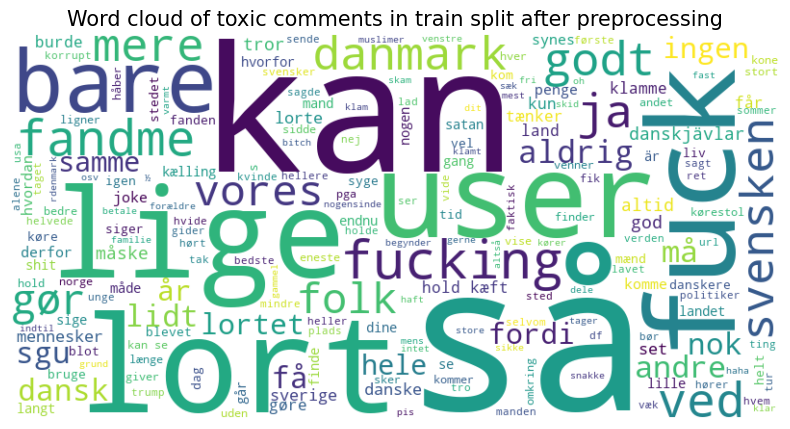

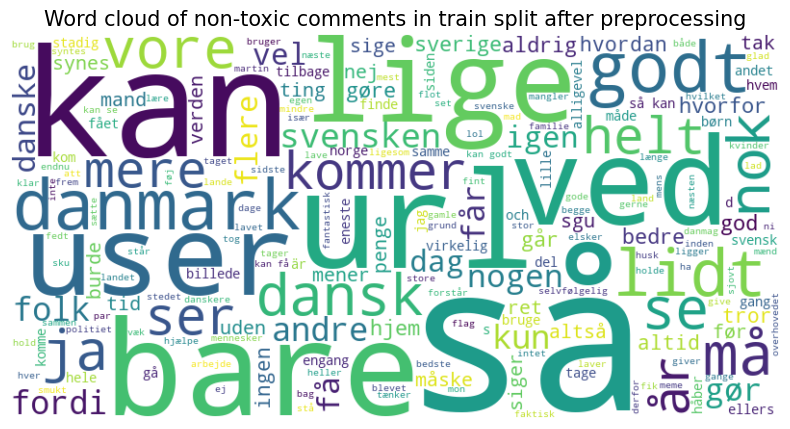

In [8]:
# plot word clouds after preprocessing
utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig_preproc, y_train_orig, mask=1), 
    title="Word cloud of toxic comments in train split after preprocessing",
    save=True, file_name="toxic_cloud_after_preprocessing.png"
    )

utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig_preproc, y_train_orig, mask=0), 
    title="Word cloud of non-toxic comments in train split after preprocessing",
    save=True, file_name="non-toxic_cloud_after_preprocessing.png"
    )

### CDS bias mitigated data

In [9]:
# preprocess train set
X_train_CDS_preproc = X_train_CDS.progress_apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

# rename test set
X_test_CDS_preproc = X_test_orig_preproc # original test data is already preprocessed
y_test_CDS = y_test_orig

print("Before preprocessing:")
display(pd.DataFrame([X_train_CDS, y_train_CDS]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_CDS, are_tokens=False)):,}")

print("\n\nAfter preprocessing:")
display(pd.DataFrame([X_train_CDS_preproc, y_train_CDS]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_CDS_preproc, are_tokens=False)):,}")

100%|██████████| 2631/2631 [00:00<00:00, 9190.51it/s]

Before preprocessing:


,Unnamed 0,label
2626,hørt,0
2627,min reaktion hvis jeg var svensker,0
2628,hey champ vil du ikke smide et link til hvor ...,0
2629,hvis du melder en for vold eller voldtægt og ...,1
2630,vi betaler for omkring 4 mb ned 500 kb op men...,0


Vocab size: 9,280


After preprocessing:


,Unnamed 0,label
2626,hørt,0
2627,reaktion svensker,0
2628,hey champ smide link ser hearthstone henne,0
2629,melder vold voldtægt viser sandt beviser diver...,1
2630,betaler omkring mb kb får nok tættere kb kb be...,0


Vocab size: 8,808


In [10]:
# pickle preprocessed versions
with open("data/X_CDS_preproc.pkl", "wb") as f:
    pickle.dump({"X_train": X_train_CDS_preproc,
                 "X_test": X_test_CDS_preproc}, f)

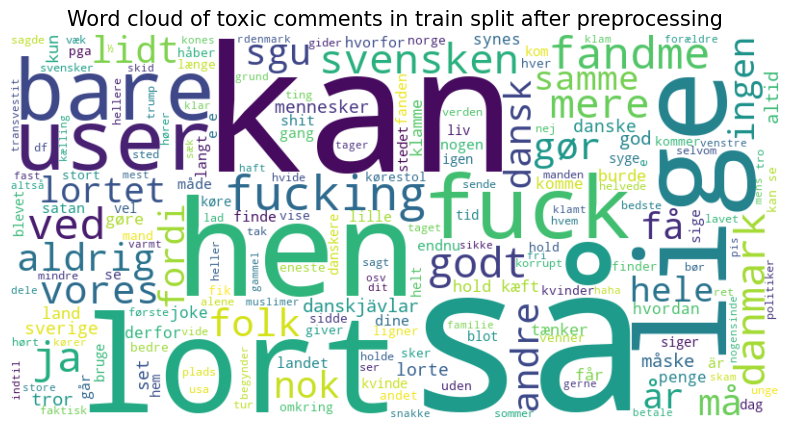

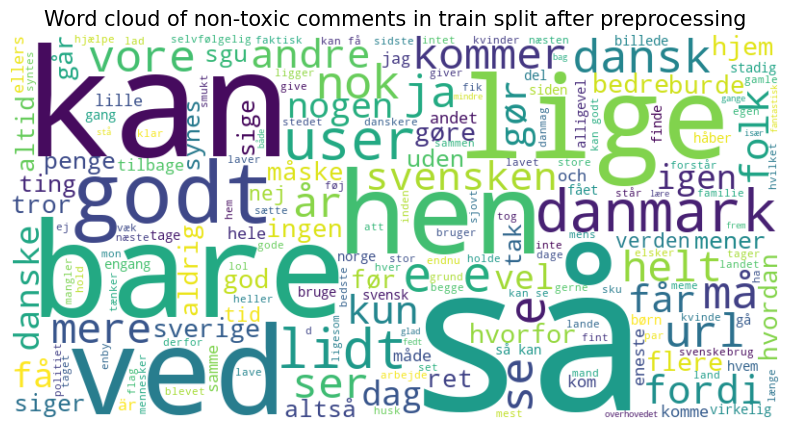

In [11]:
# plot word clouds after preprocessing
utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_CDS_preproc, y_train_CDS, mask=1), 
    title="Word cloud of toxic comments in train split after preprocessing",
    save=True, file_name="toxic_cloud_after_preprocessing.png"
    )

utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_CDS_preproc, y_train_CDS, mask=0), 
    title="Word cloud of non-toxic comments in train split after preprocessing",
    save=True, file_name="non-toxic_cloud_after_preprocessing.png"
    )

## Prepare data for models

### Original data

In [12]:
# Ensure that there are no null values
if X_train_orig_preproc.isnull().any() or X_test_orig_preproc.isnull().any():
    raise ValueError("There are missing values in the data.")

# Print shapes
print("Shapes:")
print(X_train_orig_preproc.shape, y_train_orig.shape)
print(X_test_orig_preproc.shape, y_test_orig.shape)

Shapes:
(2631,) (2631,)
(658,) (658,)


In [14]:
# fix class imbalance

# vectorize X_train
vectorizer_orig = CountVectorizer()
X_train_orig_vec = vectorizer_orig.fit_transform(X_train_orig_preproc)

# oversample the minority class
X_train_orig_oversampled, y_train_orig_oversampled = utils.oversample_data(X_train_orig_vec, y_train_orig, strategy=0.5, smote=False, SEED=42) 

# convert back to text
X_train_orig_oversampled = pd.Series([' '.join(vectorizer_orig.inverse_transform(vector)[0]) for vector in X_train_orig_oversampled])

pd.DataFrame([X_train_orig_oversampled, y_train_orig_oversampled]).T.head(10)

,Unnamed 0,label
0,hahaha,0
1,user føler svært så prøv flytte afrika får str...,0
2,endnu barriere bønder uden eu,0
3,eneste møde ved snuskede stambar aalborg altid...,0
4,godt forøvrigt taget dokumentarprogram svensk ...,0
5,plagiat url,0
6,tager vores gamle kongerige tilbage containers...,0
7,user altså heller ikk værre spaghetti bolonais...,0
8,så læs statistikker svaret dit spørgsmål,0
9,ved godt mener dfs ideologi klare nazistiske e...,0


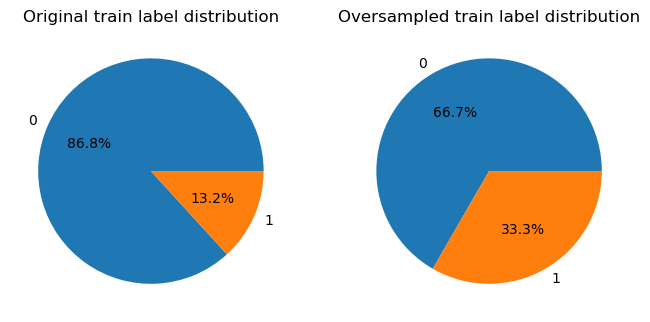

In [15]:
# plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(y_train_orig.value_counts().values,
        labels = y_train_orig.value_counts().index,
        autopct='%1.1f%%')
axes[0].set_title("Original train label distribution")

axes[1].pie(y_train_orig_oversampled.value_counts().values,
        labels = y_train_orig_oversampled.value_counts().index,
        autopct='%1.1f%%')
axes[1].set_title("Oversampled train label distribution")

plt.savefig("plots/new_label_distributions.png")
plt.show()

In [16]:
# pickle the preprocessed and oversampled splits
orig_dataset_splits = {
    "X training preprocessed and oversampled": X_train_orig_oversampled,
    "y training preprocessed and oversampled": y_train_orig_oversampled,
    "X test preprocessed": X_test_orig_preproc,
    "y test": y_test_orig
}

with open("data/orig_dataset_splits.pkl", "wb") as f:
    pickle.dump(orig_dataset_splits, f)

In [17]:
# rename splits (remove suffixes)
X_train_orig = X_train_orig_oversampled
y_train_orig = y_train_orig_oversampled
X_test_orig = X_test_orig_preproc
y_test_orig = y_test_orig

### CDS bias mitigated data

In [18]:
# Ensure that there are no null values
if X_train_CDS_preproc.isnull().any() or X_test_CDS_preproc.isnull().any():
    raise ValueError("There are missing values in the data.")

# Print shapes
print("Shapes:")
print(X_train_CDS_preproc.shape, y_train_CDS.shape)
print(X_test_CDS_preproc.shape, y_test_CDS.shape)

Shapes:
(2631,) (2631,)
(658,) (658,)


In [19]:
# fix class imbalance

# vectorize X_train
vectorizer_CDS = CountVectorizer()
X_train_CDS_vec = vectorizer_CDS.fit_transform(X_train_CDS_preproc)

# oversample the minority class
X_train_CDS_oversampled, y_train_CDS_oversampled = utils.oversample_data(X_train_CDS_vec, y_train_CDS, strategy=0.5, smote=False, SEED=42) 

# convert back to text
X_train_CDS_oversampled = pd.Series([' '.join(vectorizer_CDS.inverse_transform(vector)[0]) for vector in X_train_CDS_oversampled])

pd.DataFrame([X_train_CDS_oversampled, y_train_CDS_oversampled]).T.head(10)

,Unnamed 0,label
0,hahaha,0
1,user føler svært så prøv flytte afrika får str...,0
2,endnu barriere bønder uden eu,0
3,eneste møde ved snuskede stambar aalborg altid...,0
4,godt forøvrigt taget dokumentarprogram svensk ...,0
5,plagiat url,0
6,tager vores gamle kongerige tilbage containers...,0
7,user altså heller ikk værre spaghetti bolonais...,0
8,så læs statistikker svaret dit spørgsmål,0
9,ved godt mener dfs ideologi klare nazistiske e...,0


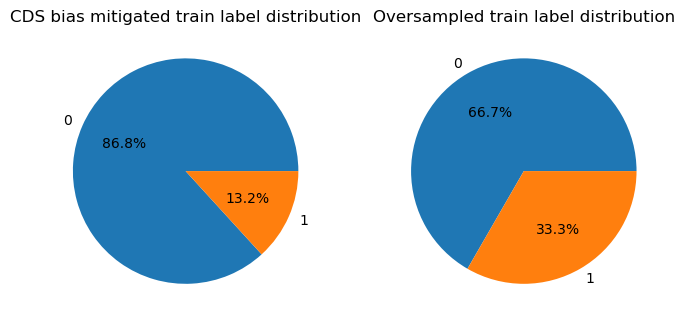

In [20]:
# plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(y_train_CDS.value_counts().values,
        labels = y_train_CDS.value_counts().index,
        autopct='%1.1f%%')
axes[0].set_title("CDS bias mitigated train label distribution")

axes[1].pie(y_train_CDS_oversampled.value_counts().values,
        labels = y_train_CDS_oversampled.value_counts().index,
        autopct='%1.1f%%')
axes[1].set_title("Oversampled train label distribution")

plt.savefig("plots/new_label_distributions_CDS.png")
plt.show()

In [21]:
# pickle the preprocessed and oversampled splits
CDS_dataset_splits = {
    "X training preprocessed and oversampled": X_train_CDS_oversampled,
    "y training preprocessed and oversampled": y_train_CDS_oversampled,
    "X test preprocessed": X_test_CDS_preproc,
    "y test": y_test_CDS
}

with open("data/CDS_dataset_splits.pkl", "wb") as f:
    pickle.dump(CDS_dataset_splits, f)

In [22]:
# rename splits (remove suffixes)
X_train_CDS = X_train_CDS_oversampled
y_train_CDS = y_train_CDS_oversampled
X_test_CDS = X_test_CDS_preproc
y_test_CDS = y_test_CDS

## Baseline model (logistic regression with unigrams)

In [23]:
# define model class
class LogRegModel:
    def __init__(self, name="LogRegModel"):
        self.name = name
        self.model = LogisticRegression()
    
    def train(self, X_train, y_train):
        """Train the model."""
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        """Use the trained model to predict the test set (classes)."""
        return self.model.predict(X_test)
    
    def predict_proba(self, X_test):
        """Use the trained model to predict the test set (probabilities)."""
        return self.model.predict_proba(X_test)
    
    def evaluate(self, X_test, y_test, ndigits=3):
        """Calculate the accuracy and classification report for the test set."""
        pred = self.predict(X_test)
        acc = accuracy_score(y_test, pred)
        report = classification_report(y_test, pred, digits=ndigits)
        return acc, report
    
    def plot_heatmap(self, X_test, y_test, title="", save=False, filename="LogRegHeatmap.png"):
        """Plot a heatmap of the predictions for the test set."""
        pred = self.predict(X_test)
        conf_matrix = confusion_matrix(y_test, pred, labels=self.model.classes_)
        utils.plot_heatmap(conf_matrix, title=title, save=save, file_name=filename)

In [24]:
# vectorization
vectorizer_baseline = TfidfVectorizer(ngram_range=(1,1)) # unigrams
vectorizer_baseline = vectorizer_baseline.fit(X_train_orig)
feat_names = vectorizer_baseline.get_feature_names_out()
X_train_baseline = vectorizer_baseline.transform(X_train_orig)
X_test_baseline = vectorizer_baseline.transform(X_test_orig)

print(f"{len(feat_names):,} unigrams in total (= number of features)\n")
print("First 5 unigrams:")
for unigram in feat_names[:5]:
    print(unigram)

print("\nShapes:")
print(X_train_baseline.shape, y_train_orig.shape)
print(X_test_baseline.shape, y_test_orig.shape)

8,709 unigrams in total (= number of features)

First 5 unigrams:
aa
aaaaah
aaaarg
aaalt
aalborg

Shapes:
(3424, 8709) (3424,)
(658, 8709) (658,)


              precision    recall  f1-score   support

           0      0.907     0.995     0.949       581
           1      0.857     0.234     0.367        77

    accuracy                          0.906       658
   macro avg      0.882     0.614     0.658       658
weighted avg      0.901     0.906     0.881       658



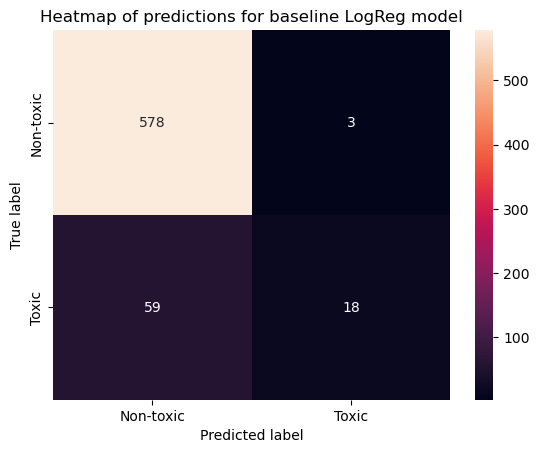

In [25]:
# BASELINE

# define and train model
baseline = LogRegModel(name="baseline model")
baseline.train(X_train_baseline, y_train_orig)

# evaluate the model
_, baseline_report = baseline.evaluate(X_test_baseline, y_test_orig)
print(baseline_report)

# plot heatmap
baseline.plot_heatmap(X_test_baseline, y_test_orig, title="Heatmap of predictions for baseline LogReg model", save=True, filename="logreg_heatmap.png")

In [26]:
overall_aucs_test_baseline = roc_auc_score(y_test_orig, baseline.predict_proba(X_test_baseline)[:,1]) # test set
print("Overall AUC:", round(overall_aucs_test_baseline,4))

Overall AUC: 0.7651


In [27]:
# save baseline
with open("models/baseline_lr.pkl", "wb") as f:
    pickle.dump(baseline, f)

# save vectorized version of X_test
with open("data/X_test_baseline.pkl", "wb") as f:
    pickle.dump(X_test_baseline, f)

# save overall auc
with open("data/overall_aucs_test_baseline.pkl", "wb") as f:
    pickle.dump(overall_aucs_test_baseline, f)

## Common for all CNNs

In [28]:
# load pre-trained embeddings

# CONLL17 embeddings
if "word2vec.model" not in os.listdir("embeddings") or "word2vec.model.vectors.npy" not in os.listdir("embeddings"):
    word_embeddings = load_wv_with_gensim('conll17.da.wv')
    word_embeddings.save("embeddings/word2vec.model")
word_embeddings = KeyedVectors.load("embeddings/word2vec.model")
EMB_DIM = 100

# # Wiki embeddings
# if "word2vecwiki.model" not in os.listdir("embeddings") or "word2vecwiki.model.vectors.npy" not in os.listdir("embeddings"):
#     word_embeddings = load_wv_with_gensim('wiki.da.wv')
#     word_embeddings.save("embeddings/word2vecwiki.model")
# word_embeddings = KeyedVectors.load("embeddings/word2vecwiki.model")
# EMB_DIM = 300

In [29]:
# explore embeddings
print("Examples of words in embeddings vocabulary:")
if GENSIM_VERSION >= 4:
    for x in list(word_embeddings.index_to_key)[:15]:
        print(x) 
else:
    for x in list(word_embeddings.vocab.keys())[:15]:
        print(x) 


print("\n___ is to 'england' as 'københavn' is to 'danmark':")
for x in word_embeddings.most_similar(positive=['københavn', 'england'], negative=['danmark'], topn=3):
    print(x)

print("\n___ is to 'kvinde' as 'dreng' is to 'mand':")
for x in word_embeddings.most_similar(positive=['dreng', 'kvinde'], negative=['mand'], topn=3):
    print(x)

Examples of words in embeddings vocabulary:
</s>
,
.
i
og
af
er
at
til
på
en
med
for
det
-

___ is to 'england' as 'københavn' is to 'danmark':
('london', 0.7156291007995605)
('edinburgh', 0.6790332794189453)
('woolwich', 0.6561344265937805)

___ is to 'kvinde' as 'dreng' is to 'mand':
('pige', 0.8950952291488647)
('skolepige', 0.792621910572052)
('legetøjsfigur', 0.7810863256454468)


In [30]:
# create word to embedding vector map
embeddings_index = {}
if GENSIM_VERSION >= 4:
    for w in word_embeddings.index_to_key:
        embeddings_index[w] = word_embeddings[w]
else:
    for w in word_embeddings.vocab.keys():
        embeddings_index[w] = word_embeddings[w]

In [35]:
# define model class
class CNNModel:
    def __init__(self, input_dim, emb_dim, emb_index, tokenizer, name="CNNModel", n_initializations=10):
        self.input_dim = input_dim
        self.emb_dim = emb_dim # embedding dimension
        self.name = name # name of model
        self.n_initializations = n_initializations
        self.emb_matrix, self.misses_list = self.map_words_to_embeddings(emb_index, tokenizer)
        self.models = [self.build_model() for _ in range(n_initializations)] # build n models 
    
    def map_words_to_embeddings(self, embeddings_index, tokenizer):
        """Map words in the training set to the pretrained word embeddings. Returns embedding matrix and list of missed words."""
        hits, misses = 0, 0
        misses_list = []
        embedding_matrix = np.zeros((self.input_dim, self.emb_dim)) # create empty embedding matrix (zeros)
        for word, i in tokenizer.word_index.items(): # for each word in training vocab
            if i >= self.input_dim:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
                misses_list.append(word)
        print(f"Converted {hits:,} words ({misses:,} misses)")
        return embedding_matrix, misses_list
        
    def build_model(self):
        """Build the individual CNN model initialization."""
        # define network
        model = Sequential()
        model.add(layers.Input(shape = (None,), dtype = "int64")) # input layer
        model.add(layers.Embedding( # embedding layer using pretrained embeddings
            input_dim = self.input_dim, 
            output_dim = self.emb_dim,
            embeddings_initializer=tf.keras.initializers.Constant(self.emb_matrix), 
            trainable=True))
        
        # add layers
        model.add(layers.Conv1D(128, 5, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(10, activation="relu"))
        model.add(layers.Dense(1, activation="sigmoid"))
        
        # compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

        return model
    
    def train(self, X_train, y_train, validation_data):
        """Train the models."""
        for model in tqdm(self.models):
            model.fit(X_train, y_train,
                        batch_size = 128, 
                        epochs = 10,
                        verbose = False,
                        validation_data = (validation_data))
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all the models and return results dictionary."""
        results = {"acc":[], "f1_macro":[], "f1_weighted":[], "f1_nontoxic":[], "f1_toxic":[]}

        for model in self.models:
            proba = model.predict(X_test)
            pred = np.where(proba > .5, 1, 0)
            
            # accuracy score
            results["acc"].append(accuracy_score(y_test, pred))
                        
            # f1 variants
            results["f1_macro"].append(f1_score(y_test, pred, average="macro"))
            results["f1_weighted"].append(f1_score(y_test, pred, average="weighted"))
            
            # per class f1 score
            f1_per_class = f1_score(y_test, pred, average=None)
            results["f1_nontoxic"].append(f1_per_class[0])
            results["f1_toxic"].append(f1_per_class[1])
        
        return results

    def evaluation_average(self, results_dict):
        """Return the average of the evaluation scores."""
        return [("avg_"+x, np.mean(results_dict[x])) for x in results_dict]
    
    def evaluation_max(self, results_dict):
        """Return the max of the evaluation scores."""
        return [("max_"+x, np.max(results_dict[x])) for x in results_dict]

    def save_models(self, prefix="CNN"):
        """Save each model initialization to a file."""
        for i, model in enumerate(self.models):
            filename = f"{prefix}_{i}.h5"
            model.save(filename)
            print(f'Model {i+1} saved as {filename}')

## CNN trained on the original dataset = Original CNN

In [36]:
# define tokenizer
tokenizer_orig = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer_orig.fit_on_texts(X_train_orig)

# prepare data for model (tokenize and pad)
X_train_orig_tokenized = tokenizer_orig.texts_to_sequences(X_train_orig)
X_test_orig_tokenized = tokenizer_orig.texts_to_sequences(X_test_orig)
X_train_orig_padded = pad_sequences(X_train_orig_tokenized, maxlen=MAXLEN, padding="post")
X_test_orig_padded = pad_sequences(X_test_orig_tokenized, maxlen=MAXLEN, padding="post")

# define model
CNN_orig = CNNModel(input_dim=NUM_WORDS, emb_dim=EMB_DIM, emb_index=embeddings_index, tokenizer=tokenizer_orig, name="original CNN model", n_initializations=10)

# check shapes of data
print("\nShapes:")
print(X_train_orig_padded.shape, y_train_orig.shape)
print(X_test_orig_padded.shape, y_test_orig.shape)

Converted 7,834 words (876 misses)

Shapes:
(3424, 330) (3424,)
(658, 330) (658,)


In [37]:
print("Missed words:")
CNN_orig.misses_list

Missed words:


['<OOV>',
 'danskjävlar',
 'rdenmark',
 'urlå',
 'upvote',
 'kraftædme',
 'lastbilvenner',
 'jävlar',
 'lorteret',
 'hæphop',
 'kioskhår',
 'tankenom',
 'ualmindeligtklamt',
 'udepressoexcesso',
 'rswarje',
 'danskjävel',
 'lortememe',
 'frihedsbedrøvelse',
 'opvokst',
 'nødenstund',
 'dansksvin',
 'spionland',
 'venligfolket',
 'skämt',
 'sortbrunasiatindermuslimetcosv',
 'værdnår',
 'tudekællingerne',
 'posthanen',
 'urlår',
 'bøfsander',
 'drooooooooooooool',
 'lortesommer',
 'nä',
 'borgerræpresentationen',
 'lortepæl',
 'hundras',
 'lorthunden',
 'dansksvensk',
 'gårdshund',
 'peruanernas',
 'bolivianernas',
 'titicakasjön',
 'återfinns',
 'grannlandets',
 'formiddagmiddag',
 'cnut',
 'postmændene',
 'cykelidiot',
 'irellevans',
 'polandball',
 'unsubscribed',
 'skånejäveln',
 'danskjäveln',
 'urlære',
 'flaskekontaneren',
 'sorligt',
 'danskjävlarna',
 'downvote',
 'rdanmag',
 'lignunge',
 'lortevarmt',
 'ikeaaber',
 'heldighvis',
 'gudforladte',
 'javle',
 'triatlons',
 'kamelås

In [38]:
# train model
CNN_orig.train(X_train_orig_padded, y_train_orig, validation_data=(X_test_orig_padded, y_test_orig))

100%|██████████| 10/10 [04:45<00:00, 28.54s/it]


In [39]:
# evaluate model 
CNN_results_orig = CNN_orig.evaluate_models(X_test_orig_padded, y_test_orig)
CNN_avg_results_orig = CNN_orig.evaluation_average(CNN_results_orig)
CNN_max_results_orig = CNN_orig.evaluation_max(CNN_results_orig)

21/21 [==============================] - 0s 6ms/step


In [41]:
# print results
for summary in [CNN_avg_results_orig, CNN_max_results_orig]:
    for (metric, score) in summary:
        print(f"{metric.capitalize().ljust(15)}: {round(score, 4)}")
    print()

Avg_acc        : 0.9065
Avg_f1_macro   : 0.7286
Avg_f1_weighted: 0.8969
Avg_f1_nontoxic: 0.9483
Avg_f1_toxic   : 0.5089

Max_acc        : 0.9119
Max_f1_macro   : 0.7602
Max_f1_weighted: 0.9048
Max_f1_nontoxic: 0.9516
Max_f1_toxic   : 0.5714



In [43]:
# calculate AUC
overall_aucs_test_orig = [roc_auc_score(y_test_orig, model.predict(X_test_orig_padded)) for model in CNN_orig.models] # test set
print("Average overall AUC:", round(np.mean(overall_aucs_test_orig), 4))
print("Max overall AUC    :", round(np.max(overall_aucs_test_orig), 4))

 1/21 [>.............................] - ETA: 0s

21/21 [==============================] - 0s 6ms/step
Average overall AUC: 0.7978
Max overall AUC    : 0.8083


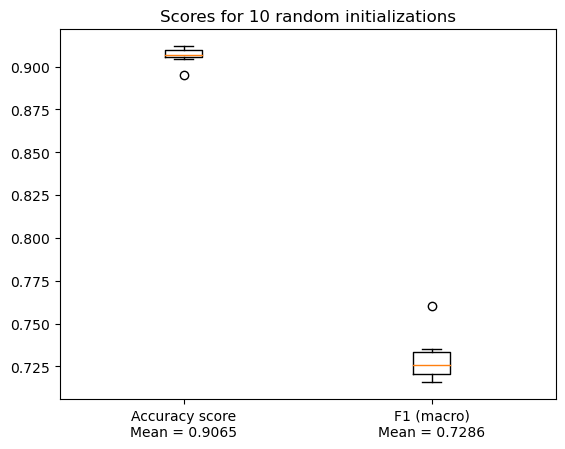

In [44]:
plt.boxplot([CNN_results_orig["acc"], CNN_results_orig["f1_macro"]])
plt.title("Scores for 10 random initializations")
plt.xticks(ticks=range(1,3), labels=
           [f"Accuracy score\nMean = {round(np.mean(CNN_results_orig['acc']), 4)}", 
            f"F1 (macro)\nMean = {round(np.mean(CNN_results_orig['f1_macro']), 4)}"])
plt.show()

In [45]:
# save models
CNN_orig.save_models("models/CNN_orig")

Model 1 saved as models/CNN_orig_0.h5
Model 2 saved as models/CNN_orig_1.h5
Model 3 saved as models/CNN_orig_2.h5
Model 4 saved as models/CNN_orig_3.h5
Model 5 saved as models/CNN_orig_4.h5
Model 6 saved as models/CNN_orig_5.h5
Model 7 saved as models/CNN_orig_6.h5
Model 8 saved as models/CNN_orig_7.h5
Model 9 saved as models/CNN_orig_8.h5
Model 10 saved as models/CNN_orig_9.h5


In [46]:
# save vectorized and padded version of X_test
with open("data/X_test_cnn.pkl", "wb") as f:
    pickle.dump(X_test_orig_padded, f)

# save tokenizer
tokenizer_json_orig = tokenizer_orig.to_json()
with open("models/tokenizer_orig.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json_orig, ensure_ascii=False))

# save overall AUCs
with open("data/overall_aucs_test_orig.pkl", "wb") as f:
    pickle.dump(overall_aucs_test_orig, f)

In [ ]:
# # Plot last model
# plot_model(cnn,
#            to_file="models/cnn_model.png",
#            show_shapes=True,
#            show_dtype=False,
#            show_layer_names=True,
#            rankdir="TB", # LR = horizontal, TB = vertical
#            expand_nested=False,
#            dpi=96,
#            layer_range=None, # if you only want to plot some layers, specify them here
#            show_layer_activations=False
#            )

## CNN trained on the CDS bias mitigated dataset = CDS CNN

In [47]:
# define tokenizer
tokenizer_CDS = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer_CDS.fit_on_texts(X_train_CDS)

# prepare data for model (tokenize and pad)
X_train_CDS_tokenized = tokenizer_CDS.texts_to_sequences(X_train_CDS)
X_test_CDS_tokenized = tokenizer_CDS.texts_to_sequences(X_test_CDS)
X_train_CDS_padded = pad_sequences(X_train_CDS_tokenized, maxlen=MAXLEN, padding="post")
X_test_CDS_padded = pad_sequences(X_test_CDS_tokenized, maxlen=MAXLEN, padding="post")

# define model
CNN_CDS = CNNModel(input_dim=NUM_WORDS, emb_dim=EMB_DIM, emb_index=embeddings_index, tokenizer=tokenizer_CDS, name="CDS CNN model", n_initializations=10)

# check shapes of data
print("\nShapes:")
print(X_train_CDS_padded.shape, y_train_CDS.shape)
print(X_test_CDS_padded.shape, y_test_CDS.shape)

Converted 7,703 words (991 misses)

Shapes:
(3424, 330) (3424,)
(658, 330) (658,)


In [48]:
print("Missed words:")
CNN_CDS.misses_list

Missed words:


['<OOV>',
 'danskjävlar',
 'enbys',
 'rdenmark',
 'enby',
 'upvote',
 'ikkebinær',
 'kraftædme',
 'omnikønnet',
 'lastbilvenner',
 'jävlar',
 'lorteret',
 'hæphop',
 'kioskhår',
 'tankenom',
 'ualmindeligtklamt',
 'udepressoexcesso',
 'rswarje',
 'danskjävel',
 'lortememe',
 'frihedsbedrøvelse',
 'opvokst',
 'nødenstund',
 'dansksvin',
 'spionland',
 'venligfolket',
 'skämt',
 'sortbrunasiatindermuslimetcosv',
 'værdnår',
 'tudekællingerne',
 'herkomsthvornår',
 'posthanen',
 'bøfsander',
 'drooooooooooooool',
 'lortesommer',
 'nä',
 'borgerræpresentationen',
 'lortepæl',
 'hundras',
 'lorthunden',
 'dansksvensk',
 'gårdshund',
 'peruanernas',
 'bolivianernas',
 'titicakasjön',
 'återfinns',
 'grannlandets',
 'formiddagmiddag',
 'urldid',
 'cnut',
 'postmændene',
 'cykelidiot',
 'irellevans',
 'nonbinær',
 'polandball',
 'twospirit',
 'unsubscribed',
 'skånejäveln',
 'danskjäveln',
 'flaskekontaneren',
 'sorligt',
 'danskjävlarna',
 'downvote',
 'rdanmag',
 'multikønnet',
 'lignunge',


In [49]:
# train model
CNN_CDS.train(X_train_CDS_padded, y_train_CDS, validation_data=(X_test_CDS_padded, y_test_CDS))

100%|██████████| 10/10 [04:42<00:00, 28.30s/it]


In [50]:
# evaluate model 
CNN_results_CDS = CNN_CDS.evaluate_models(X_test_CDS_padded, y_test_CDS)
CNN_avg_results_CDS = CNN_CDS.evaluation_average(CNN_results_CDS)
CNN_max_results_CDS = CNN_CDS.evaluation_max(CNN_results_CDS)

21/21 [==============================] - 0s 5ms/step


In [52]:
# print results
for summary in [CNN_avg_results_CDS, CNN_max_results_CDS]:
    for (metric, score) in summary:
        print(f"{metric.capitalize().ljust(15)}: {round(score, 4)}")
    print()

Avg_acc        : 0.9033
Avg_f1_macro   : 0.7176
Avg_f1_weighted: 0.893
Avg_f1_nontoxic: 0.9466
Avg_f1_toxic   : 0.4886

Max_acc        : 0.9103
Max_f1_macro   : 0.7498
Max_f1_weighted: 0.9004
Max_f1_nontoxic: 0.9508
Max_f1_toxic   : 0.5532



In [53]:
# calculate AUC
overall_aucs_test_CDS = [roc_auc_score(y_test_CDS, model.predict(X_test_CDS_padded)) for model in CNN_CDS.models] # test set
print("Average overall AUC:", round(np.mean(overall_aucs_test_CDS), 4))
print("Max overall AUC    :", round(np.max(overall_aucs_test_CDS), 4))

21/21 [==============================] - 0s 6ms/step
Average overall AUC: 0.795
Max overall AUC    : 0.8095


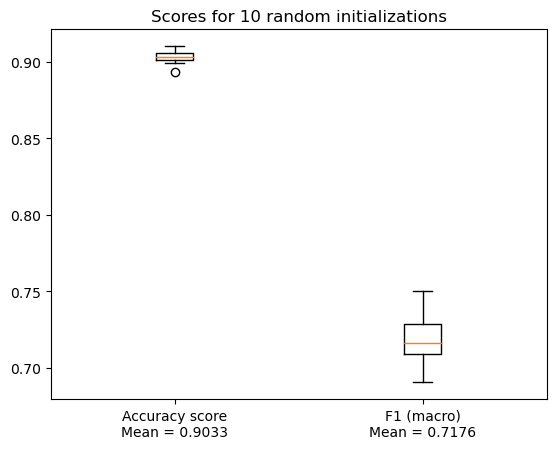

In [54]:
plt.boxplot([CNN_results_CDS["acc"], CNN_results_CDS["f1_macro"]])
plt.title("Scores for 10 random initializations")
plt.xticks(ticks=range(1,3), labels=
           [f"Accuracy score\nMean = {round(np.mean(CNN_results_CDS['acc']), 4)}", 
            f"F1 (macro)\nMean = {round(np.mean(CNN_results_CDS['f1_macro']), 4)}"])
plt.show()

In [55]:
# save models
CNN_CDS.save_models("models/CNN_CDS")

Model 1 saved as models/CNN_CDS_0.h5
Model 2 saved as models/CNN_CDS_1.h5
Model 3 saved as models/CNN_CDS_2.h5
Model 4 saved as models/CNN_CDS_3.h5
Model 5 saved as models/CNN_CDS_4.h5
Model 6 saved as models/CNN_CDS_5.h5
Model 7 saved as models/CNN_CDS_6.h5
Model 8 saved as models/CNN_CDS_7.h5
Model 9 saved as models/CNN_CDS_8.h5
Model 10 saved as models/CNN_CDS_9.h5


In [56]:
# save vectorized and padded version of X_test
with open("data/X_test_cnn_CDS.pkl", "wb") as f:
    pickle.dump(X_test_CDS_padded, f)

# save tokenizer
tokenizer_json_CDS = tokenizer_CDS.to_json()
with open("models/tokenizer_CDS.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json_CDS, ensure_ascii=False))

# save overall AUCs
with open("data/overall_aucs_test_CDS.pkl", "wb") as f:
    pickle.dump(overall_aucs_test_CDS, f)

In [ ]:
# # Plot last model
# plot_model(cnn,
#            to_file="models/cnn_model.png",
#            show_shapes=True,
#            show_dtype=False,
#            show_layer_names=True,
#            rankdir="TB", # LR = horizontal, TB = vertical
#            expand_nested=False,
#            dpi=96,
#            layer_range=None, # if you only want to plot some layers, specify them here
#            show_layer_activations=False
#            )

## Synthetic data

### Load, preprocess, and save the synthetic dataset

In [57]:
# load synthetic data
synth_data = pd.read_excel(os.getcwd()+"\\data\\synthetic_data.xlsx")
X_synth = synth_data['text']

# preprocess synthetic data
X_synth_preproc = X_synth.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

# pickle synthetic data
with open("X_synth_preproc.pkl", "wb") as f:
    pickle.dump(X_synth_preproc, f)

In [58]:
# BASELINE: vectorize synthetic data
X_synth_baseline = vectorizer_baseline.transform(X_synth_preproc)

# CNN ORIGINAL: tokenize and pad synthetic data
X_synth_orig_tokenized = tokenizer_orig.texts_to_sequences(X_synth_preproc)
X_synth_orig_padded = pad_sequences(X_synth_orig_tokenized, MAXLEN, padding="post")

# CNN CDS: tokenize and pad synthetic data
X_synth_CDS_tokenized = tokenizer_CDS.texts_to_sequences(X_synth_preproc)
X_synth_CDS_padded = pad_sequences(X_synth_CDS_tokenized, MAXLEN, padding="post")

In [59]:
# all data
y_synth = synth_data["toxic"]
print(f"{len(y_synth):,} synthetic sentences")
synth_data.head()

12,780 synthetic sentences


,text,group,identity_term,toxic,identity_lemma
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,kvinde
1,piger er klamme og generelt bare nederen,F,piger,1,pige
2,damer er klamme og generelt bare nederen,F,damer,1,dame
3,koner er klamme og generelt bare nederen,F,koner,1,kone
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,kvindfolk


### Predict the synthetic dataset using the models
Predictions are stored in the dataframe itself.

In [60]:
# baseline model
synth_data["baseline_proba"] = baseline.predict_proba(X_synth_baseline)[:,1] 
synth_data["baseline_pred"] = baseline.predict(X_synth_baseline)

In [61]:
# original CNN model
for i, model in enumerate(CNN_orig.models):
    synth_data["CNNorig_proba"+str(i)] = model.predict(X_synth_orig_padded)
    synth_data["CNNorig_pred"+str(i)] = synth_data["CNNorig_proba"+str(i)] > 0.5 # make into class prediction
    synth_data["CNNorig_pred"+str(i)] = synth_data["CNNorig_pred"+str(i)].astype(int) # convert from bool to int

400/400 [==============================] - 2s 6ms/step


In [62]:
# CDS CNN model
for i, model in enumerate(CNN_CDS.models):
    synth_data["CNNCDS_proba"+str(i)] = model.predict(X_synth_CDS_padded)
    synth_data["CNNCDS_pred"+str(i)] = synth_data["CNNCDS_proba"+str(i)] > 0.5 # make into class prediction
    synth_data["CNNCDS_pred"+str(i)] = synth_data["CNNCDS_pred"+str(i)].astype(int) # convert from bool to int

400/400 [==============================] - 2s 6ms/step


In [63]:
synth_data.head()

,text,group,identity_term,toxic,identity_lemma,baseline_proba,baseline_pred,CNNorig_proba0,CNNorig_pred0,CNNorig_proba1,...,CNNCDS_proba5,CNNCDS_pred5,CNNCDS_proba6,CNNCDS_pred6,CNNCDS_proba7,CNNCDS_pred7,CNNCDS_proba8,CNNCDS_pred8,CNNCDS_proba9,CNNCDS_pred9
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,kvinde,0.233878,0,0.747900,1,0.457620,...,0.484957,0,0.475498,0,0.902876,1,0.678822,1,0.899668,1
1,piger er klamme og generelt bare nederen,F,piger,1,pige,0.252262,0,0.875201,1,0.614721,...,0.895351,1,0.864768,1,0.986948,1,0.941711,1,0.993594,1
2,damer er klamme og generelt bare nederen,F,damer,1,dame,0.229869,0,0.790222,1,0.317485,...,0.637553,1,0.645807,1,0.942978,1,0.737272,1,0.905351,1
3,koner er klamme og generelt bare nederen,F,koner,1,kone,0.224423,0,0.848518,1,0.424486,...,0.790895,1,0.554593,1,0.851004,1,0.575225,1,0.934626,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,kvindfolk,0.239026,0,0.902128,1,0.634252,...,0.637553,1,0.645807,1,0.942978,1,0.737272,1,0.905351,1


In [64]:
synth_data.columns

Index(['text', 'group', 'identity_term', 'toxic', 'identity_lemma',
       'baseline_proba', 'baseline_pred', 'CNNorig_proba0', 'CNNorig_pred0',
       'CNNorig_proba1', 'CNNorig_pred1', 'CNNorig_proba2', 'CNNorig_pred2',
       'CNNorig_proba3', 'CNNorig_pred3', 'CNNorig_proba4', 'CNNorig_pred4',
       'CNNorig_proba5', 'CNNorig_pred5', 'CNNorig_proba6', 'CNNorig_pred6',
       'CNNorig_proba7', 'CNNorig_pred7', 'CNNorig_proba8', 'CNNorig_pred8',
       'CNNorig_proba9', 'CNNorig_pred9', 'CNNCDS_proba0', 'CNNCDS_pred0',
       'CNNCDS_proba1', 'CNNCDS_pred1', 'CNNCDS_proba2', 'CNNCDS_pred2',
       'CNNCDS_proba3', 'CNNCDS_pred3', 'CNNCDS_proba4', 'CNNCDS_pred4',
       'CNNCDS_proba5', 'CNNCDS_pred5', 'CNNCDS_proba6', 'CNNCDS_pred6',
       'CNNCDS_proba7', 'CNNCDS_pred7', 'CNNCDS_proba8', 'CNNCDS_pred8',
       'CNNCDS_proba9', 'CNNCDS_pred9'],
      dtype='object')

In [65]:
# save synthetic dataset along with the model predictions
with open("data/synth_data_with_preds.pkl", "wb") as f:
    pickle.dump(synth_data, f)

### Evaluate models on the synthetic dataset

In [66]:
# baseline model
_, baseline_report_synth = baseline.evaluate(X_synth_baseline, y_synth)
print(baseline_report_synth)

              precision    recall  f1-score   support

           0      0.500     1.000     0.667      6390
           1      0.000     0.000     0.000      6390

    accuracy                          0.500     12780
   macro avg      0.250     0.500     0.333     12780
weighted avg      0.250     0.500     0.333     12780



c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
# original CNN
CNN_results_synth_orig = CNN_orig.evaluate_models(X_synth_orig_padded, y_synth)
CNN_avg_results_synth_orig = CNN_orig.evaluation_average(CNN_results_synth_orig)
CNN_max_results_synth_orig = CNN_orig.evaluation_max(CNN_results_synth_orig)

400/400 [==============================] - 2s 5ms/step


In [68]:
# print results
for summary in [CNN_avg_results_synth_orig, CNN_max_results_synth_orig]:
    for (metric, score) in summary:
        print(f"{metric.capitalize().ljust(15)}: {round(score, 4)}")
    print()

Avg_acc        : 0.5449
Avg_f1_macro   : 0.4357
Avg_f1_weighted: 0.4357
Avg_f1_nontoxic: 0.6839
Avg_f1_toxic   : 0.1875

Max_acc        : 0.555
Max_f1_macro   : 0.4557
Max_f1_weighted: 0.4557
Max_f1_nontoxic: 0.6882
Max_f1_toxic   : 0.2232



In [69]:
# CDS CNN
CNN_results_synth_CDS = CNN_CDS.evaluate_models(X_synth_CDS_padded, y_synth)
CNN_avg_results_synth_CDS = CNN_CDS.evaluation_average(CNN_results_synth_CDS)
CNN_max_results_synth_CDS = CNN_CDS.evaluation_max(CNN_results_synth_CDS)

400/400 [==============================] - 2s 5ms/step


In [70]:
# print results
for summary in [CNN_avg_results_synth_CDS, CNN_max_results_synth_CDS]:
    for (metric, score) in summary:
        print(f"{metric.capitalize().ljust(15)}: {round(score, 4)}")
    print()

Avg_acc        : 0.5461
Avg_f1_macro   : 0.4451
Avg_f1_weighted: 0.4451
Avg_f1_nontoxic: 0.6818
Avg_f1_toxic   : 0.2084

Max_acc        : 0.5567
Max_f1_macro   : 0.4682
Max_f1_weighted: 0.4682
Max_f1_nontoxic: 0.6861
Max_f1_toxic   : 0.2537

